# 事前準備

In [ ]:
# Initializing
from google.colab import drive

drive.mount('/content/drive')
# Define constant value
RESEARCH_WORK_PATH = "/content/drive/My Drive/Colab Notebooks/BachelorResearch/"
DIR_NAME = 'melspectro_img'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 使用ディレクトリの存在確認と作成

In [ ]:
import os
if not os.path.exists(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/"):
  os.mkdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/")
if not os.path.exists(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q1"):
  os.mkdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q1")
if not os.path.exists(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q2"):
  os.mkdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q2")
if not os.path.exists(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q3"):
  os.mkdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q3")
if not os.path.exists(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q4"):
  os.mkdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q4")
if not os.path.exists(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q4"):
  os.mkdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q4")

In [ ]:
def hz2mel(f):
    """Hzをmelに変換"""
    return 2595 * np.log(f / 700.0 + 1.0)

def mel2hz(m):
    """melをhzに変換"""
    return 700 * (np.exp(m / 2595) - 1.0)
    
def melFilterBank(fs, N, numChannels=128):
    """メルフィルタバンクを作成"""
    # ナイキスト周波数（Hz）
    fmax = fs / 2
    # ナイキスト周波数（mel）
    melmax = hz2mel(fmax)
    # 周波数インデックスの最大数
    nmax = N // 2
    # 周波数解像度（周波数インデックス1あたりのHz幅）
    df = fs / N
    # メル尺度における各フィルタの中心周波数を求める
    dmel = melmax / (numChannels + 1)
    melcenters = np.arange(1, numChannels + 1) * dmel
    # 各フィルタの中心周波数をHzに変換
    fcenters = mel2hz(melcenters)
    # 各フィルタの中心周波数を周波数インデックスに変換
    indexcenter = np.round(fcenters / df)
    # 各フィルタの開始位置のインデックス
    indexstart = np.hstack(([0], indexcenter[0:numChannels - 1]))
    # 各フィルタの終了位置のインデックス
    indexstop = np.hstack((indexcenter[1:numChannels], [nmax]))
    filterbank = np.zeros((numChannels, nmax))
    for c in range(0, numChannels):
        # 三角フィルタの左の直線の傾きから点を求める
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in range(int(indexstart[c]), int(indexcenter[c])):
            filterbank[c, i] = (i - indexstart[c]) * increment
        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in range(int(indexcenter[c]), int(indexstop[c])):
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenters

In [17]:
import os
import pathlib
import librosa
import numpy as np
from matplotlib import pyplot as plt
import cv2

def min_max(x, axis=None): # do min_max normalization ?->https://atmarkit.itmedia.co.jp/ait/articles/2110/07/news027.html
    min = 0.
    max = 154.28702 
    # max = 137.74599
    x = np.abs(x)
    result = (x-min)/(max-min)
    return result

def min_max_librosa_mel(x):
  min = 0.0
  max = 0.035
  x = np.abs(x)
  result = (x-min)/(max-min)
  return result


def audio_max_magnitude(filepath,n_fft = 512,hop_length = 256): # 154.28702
  try:
    mel, sr = audio_melspectro(filepath)
    return mel.max()
  except Exception:
    print("Error in Max")
    return 0

def audio_min_magnitude(filepath,n_fft = 512,hop_length = 256): # -inf
  try:
    mel, sr = audio_melspectro(filepath)
    return mel.min()
  except Exception:
    print("Error in Min")
    return 0

def audio_min_freq(filepath, cut_th, n_fft = 512,hop_length = 256):
  # cut_th = 0.15 # 150
  # cut_th = 1e-1 # 224
  cut_index = 0
  try:
    y, sr = librosa.load(filepath)
    stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)) # オーバラップ率　0％
    stft = min_max(stft)
    for fft in stft.T:
      for i, mag in enumerate(reversed(fft)):
        if mag>cut_th:
          # cut_index = len(fft)-1-i
          if cut_index < len(fft)-1-i:
            cut_index = len(fft)-1-i
          break
    print(cut_index)
    return cut_index
  except Exception:
    return -1

def to_db(x, dBref=2e-5):
    y = 20 * np.log10(x / dBref)
    return y

def audio_stft(filepath,n_fft = 512,hop_length = 256):
  try:
    y, sr = librosa.load(filepath)
    stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)) # オーバラップ率　0％
    stft = min_max(stft)
    return stft, sr
  except Exception:
    return
    
def audio_stft_crop(filepath,crop_position=257,n_fft = 512,hop_length = 256):
  try:
    y, sr = librosa.load(filepath)
    stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)) # オーバラップ率　0％
    stft = min_max(stft)
    return stft[:crop_position,:] ,sr
  except Exception:
    return

def audio_melspectro(filepath, n_fft=512, hop_length=256):
  spectro, sr = audio_stft_crop(filepath)
  # mel_basis, fcenters = melFilterBank(sr, n_fft+2)           # MAGIC NUMBER !!!!!!!!
  mel_basis = librosa.filters.mel(sr,n_fft)
  mel = np.einsum("...ft,mf->...mt", spectro, mel_basis, optimize=True)
  mel = min_max_librosa_mel(mel)
  return mel, sr

    
def save(filepath):
  spec, sr = audio_melspectro(filepath)

  dirs = filepath.split("/")
  output_path_str = DIR_NAME + "/" + dirs[len(dirs)-2] + '/' + dirs[len(dirs)-1] # Make end of the path ex./stft/Q1/Q1.MT0018024152_9.wav
  output_path_str = pathlib.Path(filepath).parents[1] / pathlib.Path(output_path_str) # Make head of the path ex./content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s 
                                                                                        # and then, add the end of the path
  print(output_path_str)
  cv2.imwrite(str(output_path_str.parent) + '/' + output_path_str.stem + '.jpg' ,spec*255) # cv2 only support uint8(0~255) format.
  # print((stft*255).shape) # -> (257, 173)
  print("Done.")

def save_unknown(filepath):
  try:
    spec, sr = audio_melspectro(filepath)
  except TypeError:
    print("Cant open.")
    return
  dirs = filepath.split("/")
  output_path_str = 'unknown_spectro/' + dirs[len(dirs)-1] # Make end of the path ex./stft/Q1/Q1.MT0018024152_9.wav
  output_path_str = pathlib.Path(filepath).parents[1] / pathlib.Path(output_path_str) # Make head of the path ex./content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s 
                                                                                        # and then, add the end of the path
  print(output_path_str)
  if (spec.shape == (128, 173)):
    cv2.imwrite(str(output_path_str.parent) + '/' + output_path_str.stem + '.jpg' ,spec*255) # cv2 only support uint8(0~255) format.
  else :
    print("cant generate correct size")
  # print((stft*255).shape) # -> (257, 173)
  print("Done.")

def path_to_audiofiles(dir_folder):
    list_of_audio = []
    for file in os.listdir(dir_folder):
        if file.endswith(".wav"):
            directory = "%s%s" % (dir_folder, file)
            list_of_audio.append(directory)
    return list_of_audio

Q1_2s = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/Q1/"
Q2_2s = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/Q2/"
Q3_2s = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/Q3/"
Q4_2s = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/Q4/"

In [ ]:
# Search the maxium value of arrays
'''
Q1_max = -1
for audio in path_to_audiofiles(Q1_2s):
  tmp = audio_max_magnitude(audio)
  if (tmp > Q1_max):
    Q1_max = tmp
Q2_max = -1
for audio in path_to_audiofiles(Q2_2s):
  tmp = audio_max_magnitude(audio)
  if (tmp > Q2_max):
    Q2_max = tmp
Q3_max = -1
for audio in path_to_audiofiles(Q3_2s):
  tmp = audio_max_magnitude(audio)
  if (tmp > Q3_max):
    Q3_max = tmp
Q4_max = -1
for audio in path_to_audiofiles(Q4_2s):
  tmp = audio_max_magnitude(audio)
  if (tmp > Q4_max):
    Q4_max = tmp

max_of_all = max(Q1_max,Q2_max,Q3_max,Q4_max)
print(max_of_all)

Q1_min = 1e9
for audio in path_to_audiofiles(Q1_2s):
  tmp = audio_min_magnitude(audio)
  if (tmp < Q1_min):
    Q1_min = tmp
Q2_min = 1e9
for audio in path_to_audiofiles(Q2_2s):
  tmp = audio_min_magnitude(audio)
  if (tmp < Q2_min):
    Q2_min = tmp
Q3_min = 1e9
for audio in path_to_audiofiles(Q3_2s):
  tmp = audio_min_magnitude(audio)
  if (tmp < Q3_min):
    Q3_min = tmp
Q4_min = 1e9
for audio in path_to_audiofiles(Q4_2s):
  tmp = audio_min_magnitude(audio)
  if (tmp < Q4_min):
    Q4_min = tmp

min_of_all = min(Q1_min,Q2_min,Q3_min,Q4_min)
print(min_of_all)
'''

'\nQ1_max = -1\nfor audio in path_to_audiofiles(Q1_2s):\n  tmp = audio_max_magnitude(audio)\n  if (tmp > Q1_max):\n    Q1_max = tmp\nQ2_max = -1\nfor audio in path_to_audiofiles(Q2_2s):\n  tmp = audio_max_magnitude(audio)\n  if (tmp > Q2_max):\n    Q2_max = tmp\nQ3_max = -1\nfor audio in path_to_audiofiles(Q3_2s):\n  tmp = audio_max_magnitude(audio)\n  if (tmp > Q3_max):\n    Q3_max = tmp\nQ4_max = -1\nfor audio in path_to_audiofiles(Q4_2s):\n  tmp = audio_max_magnitude(audio)\n  if (tmp > Q4_max):\n    Q4_max = tmp\n\nmax_of_all = max(Q1_max,Q2_max,Q3_max,Q4_max)\nprint(max_of_all)\n\nQ1_min = 1e9\nfor audio in path_to_audiofiles(Q1_2s):\n  tmp = audio_min_magnitude(audio)\n  if (tmp < Q1_min):\n    Q1_min = tmp\nQ2_min = 1e9\nfor audio in path_to_audiofiles(Q2_2s):\n  tmp = audio_min_magnitude(audio)\n  if (tmp < Q2_min):\n    Q2_min = tmp\nQ3_min = 1e9\nfor audio in path_to_audiofiles(Q3_2s):\n  tmp = audio_min_magnitude(audio)\n  if (tmp < Q3_min):\n    Q3_min = tmp\nQ4_min = 1e9\n

filter created by user

min=0.0

max=1.0

filter created by librosa

min=0.0

max=0.035

[[1.0533350e-01 2.5198512e-02 1.7329963e-02 ... 2.7162677e-03
  2.9022349e-03 1.5317202e-03]
 [2.1352600e-01 5.1080972e-02 3.5130300e-02 ... 5.5062613e-03
  5.8832434e-03 3.1050148e-03]
 [1.2946956e-01 2.3657504e-01 2.0052299e-01 ... 1.4157259e-02
  7.2836736e-03 1.8722611e-02]
 ...
 [4.2855571e-04 1.4708561e-03 5.4609874e-04 ... 3.2336703e-03
  3.6652966e-03 2.0945030e-03]
 [2.8785691e-04 9.3009282e-04 4.4028406e-04 ... 2.5980035e-03
  2.7193900e-03 1.2080788e-03]
 [3.8205218e-04 2.0027341e-04 1.0072275e-04 ... 4.6542886e-04
  2.7458268e-04 5.0438009e-04]]
min 6.5077925e-06
max 0.5657808


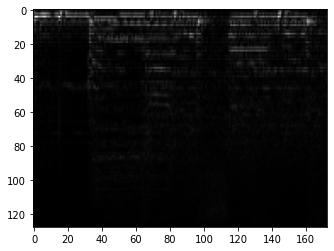

(128, 173)


In [ ]:
audio = "/content/drive/MyDrive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/Q1/Q1.MT0000249842_10.wav"
s, sr = audio_melspectro(audio)
print(s)
print("min", np.min(s))
print("max", np.max(s))
plt.imshow(s, cmap="gray")
plt.show()
print(s.shape)

In [ ]:
for audio in path_to_audiofiles(Q1_2s):
  save(audio)

ストリーミング出力は最後の 5000 行に切り捨てられました。
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q1/Q1.MT0012798988_1.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q1/Q1.MT0012798988_2.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q1/Q1.MT0012798988_4.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q1/Q1.MT0012798988_3.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q1/Q1.MT0012798988_6.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q1/Q1.MT0012798988_7.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q1/Q1.MT0012798988_5.wav
Done.
/content/drive/My Drive/Colab 

In [ ]:
for audio in path_to_audiofiles(Q2_2s):
  save(audio)

ストリーミング出力は最後の 5000 行に切り捨てられました。
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q2/Q2.MT0011458668_14.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q2/Q2.MT0008733057_2.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q2/Q2.MT0008733057_4.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q2/Q2.MT0008733057_3.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q2/Q2.MT0008733057_5.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q2/Q2.MT0008733057_6.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q2/Q2.MT0008733057_7.wav
Done.
/content/drive/My Drive/Colab

In [ ]:
for audio in path_to_audiofiles(Q3_2s):
  save(audio)

ストリーミング出力は最後の 5000 行に切り捨てられました。
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q3/Q3.MT0011836290_2.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q3/Q3.MT0011836290_1.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q3/Q3.MT0011836290_3.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q3/Q3.MT0011836290_6.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q3/Q3.MT0011836290_4.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q3/Q3.MT0011836290_5.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q3/Q3.MT0011836290_8.wav
Done.
/content/drive/My Drive/Colab 

In [ ]:
for audio in path_to_audiofiles(Q4_2s):
  save(audio)

ストリーミング出力は最後の 5000 行に切り捨てられました。
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q4/Q4.MT0000369789_14.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q4/Q4.MT0005608787_2.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q4/Q4.MT0005608787_4.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q4/Q4.MT0005608787_3.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q4/Q4.MT0005608787_5.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q4/Q4.MT0005608787_7.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/melspectro_img/Q4/Q4.MT0005608787_6.wav
Done.
/content/drive/My Drive/Colab

In [19]:
unknown = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/unknown/"
if not os.path.exists("/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/unknown_spectro/"):
  os.mkdir("/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/unknown_spectro/")
for audio in path_to_audiofiles(unknown):
  save_unknown(audio)

/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/unknown_spectro/Q2.MT0010736208_9.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/unknown_spectro/Q2.MT0010736208_10.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/unknown_spectro/Q2.MT0010736208_11.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/unknown_spectro/Q2.MT0010736208_12.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/unknown_spectro/Q2.MT0010736208_13.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/unknown_spectro/Q2.MT0010736208_14.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/unknown_spectro/Q2.MT0030160582_1.wav
Done.
/content/drive/My Drive/Colab Notebooks/BachelorResearch/MER_audio_taff

In [ ]:
def count_file(folder_path):

  import pathlib
  initial_count = 0
  for path in pathlib.Path(folder_path).iterdir():
    if path.is_file():
      initial_count += 1

  return(initial_count)

In [ ]:
# How many datas?    
print("[INFO] Datas in /2s/" + DIR_NAME + "/Q1: ", end='')
print(count_file(RESEARCH_WORK_PATH + "/MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q1"))
print("[INFO] Datas in /2s/" + DIR_NAME + "/Q2: ", end='')
print(count_file(RESEARCH_WORK_PATH + "/MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q2"))
print("[INFO] Datas in /2s/" + DIR_NAME + "/Q3: ", end='')
print(count_file(RESEARCH_WORK_PATH + "/MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q3"))
print("[INFO] Datas in /2s/" + DIR_NAME + "/Q4: ", end='')
print(count_file(RESEARCH_WORK_PATH + "/MER_audio_taffc_dataset_wav/2s/" + DIR_NAME + "/Q4"))

[INFO] Datas in /2s/melspectro_img/Q1: 2800
[INFO] Datas in /2s/melspectro_img/Q2: 2800
[INFO] Datas in /2s/melspectro_img/Q3: 2800
[INFO] Datas in /2s/melspectro_img/Q4: 2800
